In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 136818465.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41357355.35it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39522541.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9172137.11it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

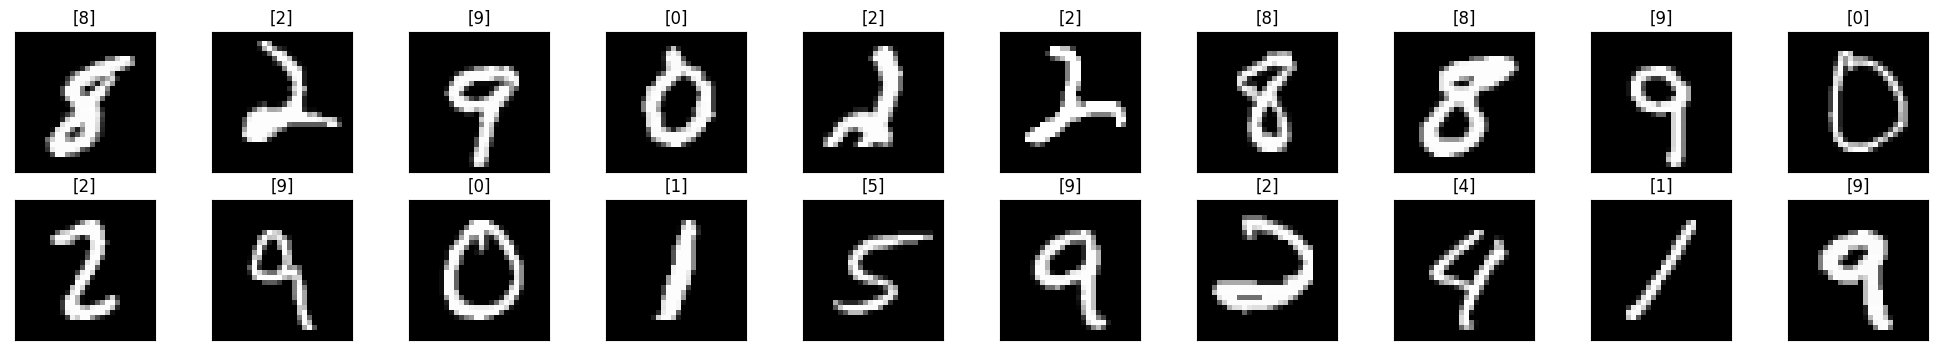

In [5]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [6]:
from torch.nn.modules import dropout
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,20,5,1)
    self.conv2 = nn.Conv2d(20,50,5,1)
    self.fc1   = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2   = nn.Linear(500, 10)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1,4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x
    

In [7]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [9]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  ###TREINAMENTO
  for inputs, labels in training_loader:
    #cast na gpu
    inputs = inputs.to(device)
    labels = labels.to(device)    

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
 ###VALIDACAO
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        #cast na gpu
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    ### TREINAMENTO
    #Cálculo da perda e acurácia média da época de treinamento:
    epoch_loss = running_loss/len(training_loader)              #Divide a soma acumulada da perda de treinamento pelo número de lotes no conjunto de treinamento 
    epoch_acc = running_corrects.float()/ len(training_loader)  #Divide a soma acumulada do número de previsões corretas pelo número total de amostras para pegar a acurácia média da época de treinamento.
    #Armazenamento das estatísticas de treinamento:
    running_loss_history.append(epoch_loss)                     #da o append na lista que registra o histórico das perdas de treinamento em cada época.
    running_corrects_history.append(epoch_acc)                  #da o append na lista que registra o histórico das acurácias de treinamento em cada época.
    
    ### VALIDACAO
    #Cálculo da perda e acurácia média da época de validação:
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    #Armazenamento das estatísticas de validação:
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    ###PRINTA OS RESULTADOS
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.1876, acc 94.2700 
validation loss: 0.0532, validation acc 98.3800 
epoch : 2
training loss: 0.0535, acc 98.3400 
validation loss: 0.0397, validation acc 98.8000 
epoch : 3
training loss: 0.0383, acc 98.7867 
validation loss: 0.0331, validation acc 98.8600 
epoch : 4
training loss: 0.0313, acc 99.0850 
validation loss: 0.0356, validation acc 98.8800 
epoch : 5
training loss: 0.0236, acc 99.2717 
validation loss: 0.0338, validation acc 99.0000 
epoch : 6
training loss: 0.0222, acc 99.2900 
validation loss: 0.0397, validation acc 98.8700 
epoch : 7
training loss: 0.0195, acc 99.3850 
validation loss: 0.0331, validation acc 99.0400 
epoch : 8
training loss: 0.0165, acc 99.4833 
validation loss: 0.0400, validation acc 98.8900 
epoch : 9
training loss: 0.0143, acc 99.5367 
validation loss: 0.0335, validation acc 99.0500 
epoch : 10
training loss: 0.0150, acc 99.5367 
validation loss: 0.0370, validation acc 99.1100 


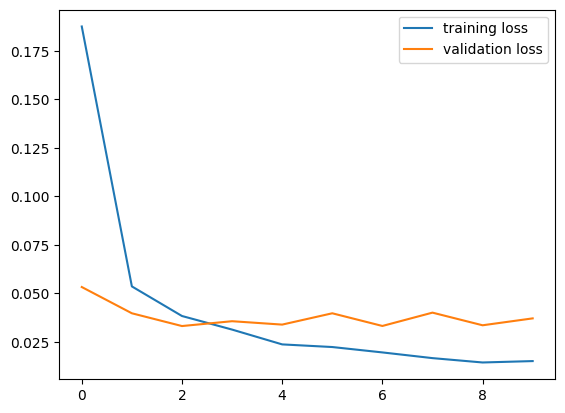

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

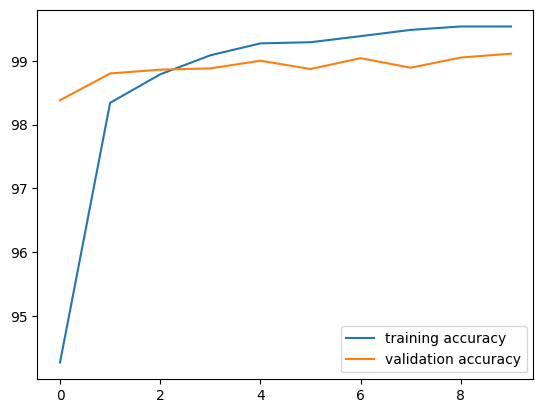

In [11]:
running_corrects_history1=[]
for i in range(len(running_corrects_history)):
  running_corrects_history1.append(running_corrects_history[i].item())

val_running_corrects_history1=[]
for i in range(len(val_running_corrects_history)):
  val_running_corrects_history1.append(val_running_corrects_history[i].item())


plt.plot(running_corrects_history1, label='training accuracy')
plt.plot(val_running_corrects_history1, label='validation accuracy')
plt.legend()

In [12]:
running_corrects_history1

[94.2699966430664,
 98.33999633789062,
 98.78666687011719,
 99.08499908447266,
 99.27166748046875,
 99.29000091552734,
 99.38500213623047,
 99.48332977294922,
 99.53666687011719,
 99.53666687011719]

In [13]:
import PIL.ImageOps
import requests
from PIL import Image


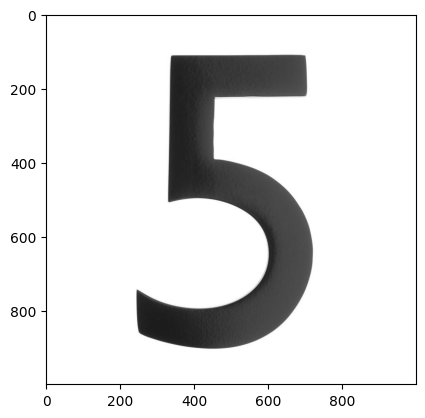

In [14]:
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

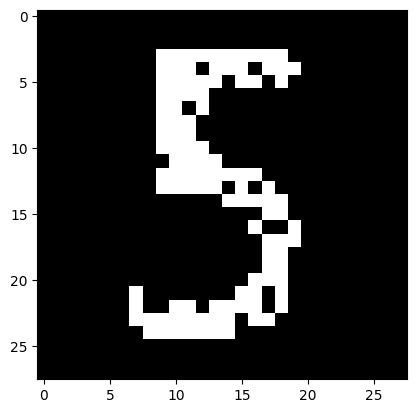

In [15]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [16]:
img = img.to(device)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


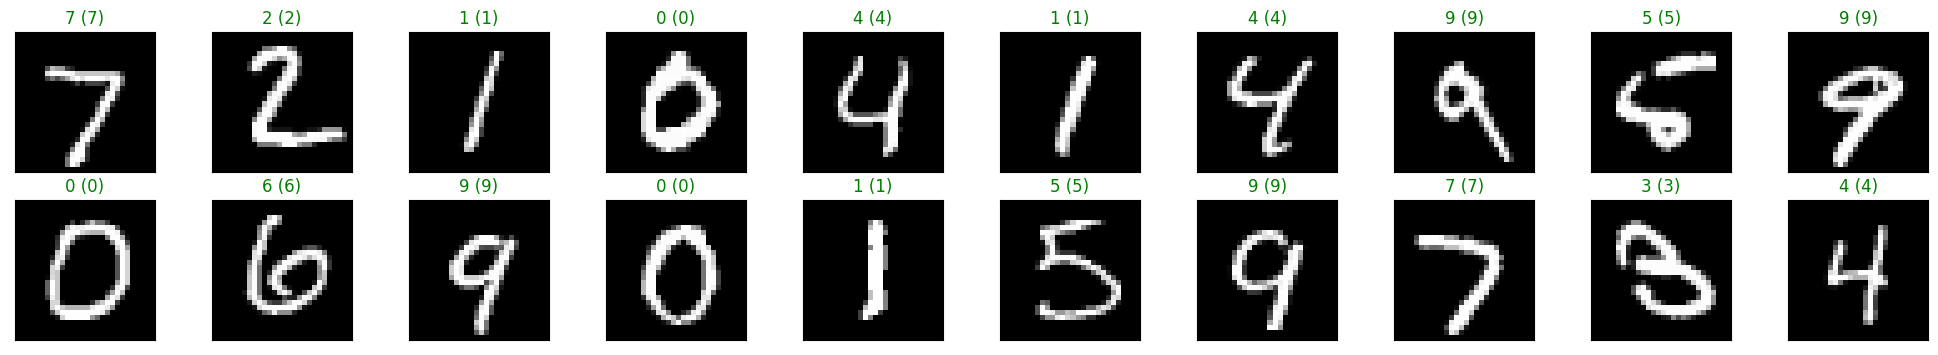

In [17]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))